<font color="red" size=4>Kaggle competition **Tabular Playground Series - May 2022** final solution kernel</font>
- May 2022 PLayground competition was binary classificationbased on tabular data, 
- My personal goal was to evaluate two implementations of neutal network dedicated to solve tabular data problems
> - the first TabNet implementation was based on Tensorflow framework
> - the second - Torch framework
- I was interested in several aspects of comparison, but especially:
> - the results in comparison with my favourite tools used for this kind of problem 
<br>(one of gradient boosting solutions (XGBoost/LightGBM/CatBoost))
> - the comparison working speed of Tensorflow and Torch implmentation

Theere were train data composed of 900 000 records and test data (700 000).
The features were:
- in some part numerical (float and continuous), 
- in come - categorical (with 2 to 16 levels) 
- one more complex feature, 30 of them all over.

This script contains the final solution, composed of traiing and prediction using:
1. Tensorflow TabNet implementation
2. PyTorch TabNet implementation
3. XGB, LightGBM and CatBoost implementation

The final conclusion is:
- **On overall, any of tested TabNet implementation performs better than boosters**
- **The price of this performance improvement one must accept to pay**  is much longer time of neural based solution training 

The final score I achieved during the competition was 0.99810 in comparison to 0.99833 winning value

In [2]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH']='true'
import numpy as np
import pandas as pd
import itertools
import warnings
import lightgbm
import sklearn
import xgboost
import catboost
import matplotlib.ticker as ticker
import datetime as dt
from tabulate import tabulate
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import tensorflow as tf
from tabnet.models.classify import TabNetClassifier as TFTabnetClassifier
from tensorflow.keras.callbacks import EarlyStopping
from tabnet.schedules import DecayWithWarmupSchedule
from tensorflow.keras.callbacks import Callback
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint
from pytorch_tabnet.tab_model import TabNetClassifier as TorchTabnetClassifier
import torch
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier

for m in [pd,sklearn,xgboost, catboost, lightgbm, tf, torch]:
    print(f"{m.__name__}: {m.__version__}")
    
pd.options.display.max_columns=0
warnings.filterwarnings('ignore')

pandas: 1.4.2
sklearn: 1.0.2
xgboost: 1.6.0
catboost: 1.0.5
lightgbm: 3.3.2
tensorflow: 2.4.0
torch: 1.10.1+cu102


# Data preparation

## Loading

In [3]:
# Oryginal Kaggle csv converted to pickle to save space
# visit https://www.kaggle.com/competitions/tabular-playground-series-may-2022/data

SRCTRAIN="/mnt/workdata/_WORK_/Kaggle_202005_Tab/Data/oryginal/pkl/train.pkl"
SRCTEST="/mnt/workdata/_WORK_/Kaggle_202005_Tab/Data/oryginal/pkl/test.pkl"

train_df = pd.read_pickle(SRCTRAIN)
test_df = pd.read_pickle(SRCTEST)

df=train_df.append(test_df)
target=df['target']
df=df.iloc[:,:-1]

In [4]:
train_df.head()


,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,target
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-1.373246,0.238887,-0.243376,0.567405,-0.647715,0.839326,0.113133,1,5,1,3,3,3,1,6,1,0,7,4,0.298218,-0.919717,3.058541,-2.540739,0.766952,-2.730628,-0.208177,1.363402,ABABDADBAB,67.609153,0,0,0
1,1.697021,-1.710322,-2.230332,-0.545661,1.113173,-1.552175,0.447825,1,3,4,0,2,3,0,1,0,4,6,0,-3.147667,-1.075434,2.179050,2.278315,-0.633658,-1.217077,-3.782194,-0.058316,ACACCADCEB,377.096415,0,0,1
2,1.681726,0.616746,-1.027689,0.810492,-0.609086,0.113965,-0.708660,1,0,2,6,6,4,3,1,2,2,1,4,2.820733,-3.485342,-0.784235,-1.385775,-0.520558,-0.009121,2.788536,-3.703488,AAAEABCKAD,-195.599702,0,2,1
3,-0.118172,-0.587835,-0.804638,2.086822,0.371005,-0.128831,-0.282575,3,2,1,0,1,6,4,2,3,3,0,3,1.081084,-2.100177,-2.343819,0.572594,-1.653213,1.686035,-2.533098,-0.608601,BDBBAACBCB,210.826205,0,0,1
4,1.148481,-0.176567,-0.664871,-1.101343,0.467875,0.500117,0.407515,3,3,0,4,3,0,6,0,3,3,1,0,-0.126179,0.605033,1.133665,-3.912929,-1.430366,2.127649,-3.306784,4.371371,BDBCBBCHFE,-217.211798,0,1,1


## F27 decomposition

### Pattern distance

In [5]:
z_distance_data_cols = [f"f_27_{i+1}" for i in range(10)]
z_distance_data = pd.DataFrame(df['f_27'].apply(list).tolist(), columns=z_distance_data_cols)
for feature in z_distance_data_cols:
    z_distance_data[feature] = z_distance_data[feature].apply(lambda x: ord('Z') - ord(x))
z_distance_data.head()

,f_27_1,f_27_2,f_27_3,f_27_4,f_27_5,f_27_6,f_27_7,f_27_8,f_27_9,f_27_10
0,25,24,25,24,22,25,22,24,25,24
1,25,23,25,23,23,25,22,23,21,24
2,25,25,25,21,25,24,23,15,25,22
3,24,22,24,24,25,25,23,24,23,24
4,24,22,24,23,24,24,23,18,20,21


In [6]:
df=df.join(z_distance_data)

## Other features

In [7]:
df['f_27_uc'] = df['f_27'].apply(lambda x : len(set(x)))


## Interaction features

In [8]:
df["f_02_f_21_sum_hist"] = df.apply(lambda r: 1 if (r['f_02']+r['f_21'])<-5.3 else 2 if (r['f_02']+r['f_21'])>5.2 else 0, axis=1)
df["f_05_f_22_sum_hist"] = df.apply(lambda r: 1 if (r['f_05']+r['f_22'])<-5.4 else 2 if (r['f_05']+r['f_22'])>5.1 else 0, axis=1)
df["f_00_01_26"] = df.apply(lambda r: 2 if (r['f_00']+r['f_01']+r["f_26"])<-5 else 1 if (r['f_00']+r['f_01']+r["f_26"])>5 else 0 , axis=1)

## Final dataset

In [9]:
df=df.join(target)
del df['f_27']

In [10]:
print(df.shape)
df.head()

(1600000, 45)


,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_28,f_29,f_30,f_27_1,f_27_2,f_27_3,f_27_4,f_27_5,f_27_6,f_27_7,f_27_8,f_27_9,f_27_10,f_27_uc,f_02_f_21_sum_hist,f_05_f_22_sum_hist,f_00_01_26,target
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-1.373246,0.238887,-0.243376,0.567405,-0.647715,0.839326,0.113133,1,5,1,3,3,3,1,6,1,0,7,4,0.298218,-0.919717,3.058541,-2.540739,0.766952,-2.730628,-0.208177,1.363402,67.609153,0,0,25,24,25,24,22,25,22,24,25,24,3,0,0,0,0.0
1,1.697021,-1.710322,-2.230332,-0.545661,1.113173,-1.552175,0.447825,1,3,4,0,2,3,0,1,0,4,6,0,-3.147667,-1.075434,2.179050,2.278315,-0.633658,-1.217077,-3.782194,-0.058316,377.096415,0,0,25,23,25,23,23,25,22,23,21,24,5,0,0,0,1.0
2,1.681726,0.616746,-1.027689,0.810492,-0.609086,0.113965,-0.708660,1,0,2,6,6,4,3,1,2,2,1,4,2.820733,-3.485342,-0.784235,-1.385775,-0.520558,-0.009121,2.788536,-3.703488,-195.599702,0,2,25,25,25,21,25,24,23,15,25,22,6,0,0,0,1.0
3,-0.118172,-0.587835,-0.804638,2.086822,0.371005,-0.128831,-0.282575,3,2,1,0,1,6,4,2,3,3,0,3,1.081084,-2.100177,-2.343819,0.572594,-1.653213,1.686035,-2.533098,-0.608601,210.826205,0,0,24,22,24,24,25,25,23,24,23,24,4,0,0,0,1.0
4,1.148481,-0.176567,-0.664871,-1.101343,0.467875,0.500117,0.407515,3,3,0,4,3,0,6,0,3,3,1,0,-0.126179,0.605033,1.133665,-3.912929,-1.430366,2.127649,-3.306784,4.371371,-217.211798,0,1,24,22,24,23,24,24,23,18,20,21,6,0,0,1,1.0


In [11]:
train_df=df.loc[pd.isna(df['target'])==False,:]
train_df['target']=train_df['target'].astype(int)
test_df=df.loc[pd.isna(df['target'])==True,:].iloc[:,:-1]
print(train_df.shape)
print(test_df.shape)

(900000, 45)
(700000, 44)


## Data crossvalidation

In [13]:
CV_DATA='crossvalidated_10_dataset.pkl'
if os.path.isfile(CV_DATA):
    print(f'Loading crossvalidated data from {CV_DATA}')
    with open(CV_DATA, "rb") as f:
        folds = pickle.load(f)
else :
    print(f'Building crossvalidated data and storing as {CV_DATA}')
    NUM_SPLITS=10
    skf = StratifiedKFold(n_splits=NUM_SPLITS)
    folds = dict()
    folds_results = dict()

    idx = 0
    train_data=train_df.iloc[:,:-1]
    train_labels=train_df.iloc[:,-1]

    for split in skf.split(train_data, train_labels ):
        folds[idx] = {'X_train': train_data.iloc[split[0],:], 
                      'y_train':  train_labels.iloc[split[0]], 
                      'X_val': train_data.iloc[split[1],:], 
                      'y_val':  train_labels.iloc[split[1]]
                      }
        print(f"Fold: {idx}, X_train {folds[idx]['X_train'].shape}, X_val {folds[idx]['X_val'].shape}")
        idx+=1
    
    with open(CV_DATA, "wb") as f:
        pickle.dump(folds, f)


Building crossvalidated data and storing as crossvalidated_10_dataset.pkl
Fold: 0, X_train (810000, 44), X_val (90000, 44)
Fold: 1, X_train (810000, 44), X_val (90000, 44)
Fold: 2, X_train (810000, 44), X_val (90000, 44)
Fold: 3, X_train (810000, 44), X_val (90000, 44)
Fold: 4, X_train (810000, 44), X_val (90000, 44)
Fold: 5, X_train (810000, 44), X_val (90000, 44)
Fold: 6, X_train (810000, 44), X_val (90000, 44)
Fold: 7, X_train (810000, 44), X_val (90000, 44)
Fold: 8, X_train (810000, 44), X_val (90000, 44)
Fold: 9, X_train (810000, 44), X_val (90000, 44)


# Tensorflow TabNet prediction
- this is slightly modified Tensorflow TabNet implementation, made by Olivier St-Amand, see <a href=https://github.com/ostamand/tensorflow-tabnet>this GitHub repo</a>
- good <a href=https://www.kaggle.com/code/marcusgawronsky/tabnet-in-tensorflow-2-0/notebook>text on TabNet implementation in Tensorflow</a>


## Params definition

In [14]:
# The parameters were determined using 80 iterations of simulated anneal, non-crossvalidated, preserving only data proportion

params = {
  "max_epochs": 1000,
  "validation_fraction": 0.1,
  "early_stopping_rounds": 10,
  "tabnet_feature_dim": 40,
  "tabnet_output_dim": 32,
  "tabnet_n_step": 3,
  "relaxation_factor": 1.623339750566143,
  "tabnet_bn_momentum": 0.8058338198783632,
  "tabnet_dp": 0.,
  "initial_learning_rate": 0.04,
  "num_warmup_epochs": 7,
  "tabnet_bn_virtual_divider": 1,
  "lr_decay_rate": 0.8018089123605378,
  "decay_steps": 700,
  "min_learning_rate": 0.000001,
  "adam_clipnorm": 2.2582474516246567,
  "batch_size": 2048
}

## CV folds training

In [15]:
# to use results for stacking or blending
# define placeholders for validation data predictions and test data predictions
folds_results = dict()
test_predictions=dict()
folds_scores={}

In [16]:
# supporting class for extended reporting
# a convenient way to report epochs to MLFlow or Microsoft NNI
class AUCCallback(Callback):
    def __init__(self, validation_data, validation_labels):
        self.x = validation_data
        self.y = validation_labels
        self.print_header=True
        self.scores=dict()
        self.history=dict()
        self.start=dt.datetime.now()

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.x)
        auc = roc_auc_score(self.y.values, y_pred[:, 1])
        if self.print_header:
            print("No:\tTrain ACC:\tTrain loss:\tVal ACC:\tVal loss:\tVal AUC:\tDuration:")
            self.print_header=False
        print(f"{epoch}\t{logs['accuracy']:.6f}\t{logs['loss']:.6f}\t{logs['val_accuracy']:.6f}\t{logs['val_loss']:.6f}\t{auc:.6f}\t{dt.datetime.now()-self.start}")
        logs['AUC']=auc
        self.scores[epoch]=auc
        self.history[epoch]={'loss':logs['loss'], 'accuracy':logs['accuracy'],
                             'val_loss': logs['val_loss'], 'val_accuracy':logs['val_accuracy'], 'val_auc':auc}
        return

In [17]:
def plot_training_history(training_history:dict):
    hdf=pd.DataFrame.from_dict(training_history, orient='index').reset_index()
    fig, ax=plt.subplots(1,2,figsize=(16,8), sharex = True)
    sns.lineplot(data=hdf, x='index', y='loss', ax=ax[0])
    sns.lineplot(data=hdf, x='index', y='val_loss', ax=ax[0])
    ax[0].set_title('Training and validation loss')
    ax[0].grid('both')
    ax[0].legend(['training loss','validation loss'])
    
    sns.lineplot(data=hdf, x='index', y='accuracy', ax=ax[1])
    sns.lineplot(data=hdf, x='index', y='val_accuracy', ax=ax[1])
    sns.lineplot(data=hdf, x='index', y='val_auc', ax=ax[1])
    ax[1].set_title('Accuracy and AUC')
    ax[1].grid('both')
    ax[1].legend(['training accuracy','validation accuracy', 'validation AUC'])
    
    plt.show()

### Training loop

Starting fold 0
Starting attempt 0 in fold 0


2022-06-03 17:46:32.744172: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-06-03 17:46:33.305666: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.853612	0.317484	0.925122	0.193875	0.977103	0:00:28.268086
1	0.936625	0.163357	0.943478	0.146642	0.987079	0:00:50.088044
2	0.949583	0.133137	0.952000	0.127672	0.989701	0:01:11.889215
3	0.953405	0.124090	0.954022	0.122240	0.990604	0:01:33.670662
4	0.956994	0.114221	0.959811	0.109389	0.992467	0:01:55.367175
5	0.957363	0.114003	0.960678	0.105564	0.992891	0:02:17.163113
6	0.960764	0.104249	0.959333	0.106385	0.992917	0:02:38.900548
7	0.961202	0.103432	0.960100	0.105353	0.993029	0:03:00.564814
8	0.960535	0.106178	0.958111	0.116614	0.991269	0:03:22.165124
9	0.960011	0.108265	0.961022	0.101357	0.993563	0:03:43.827504
10	0.963982	0.094583	0.961478	0.100609	0.993777	0:04:05.413443
11	0.965744	0.088715	0.963300	0.094765	0.994530	0:04:27.107099
12	0.966952	0.085851	0.958378	0.108451	0.993567	0:04:48.866560
13	0.967030	0.085638	0.965756	0.087247	0.995186	0:05:10.725687
14	0.967678	0.083936	0.966822	0.085262	0.995458	0:05:32.434457


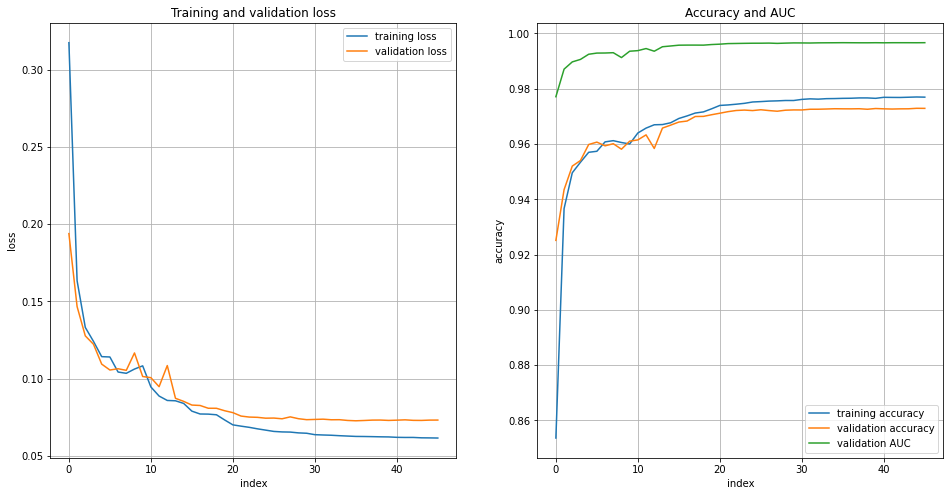

Starting attempt 1 in fold 0
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.867231	0.285828	0.938467	0.151323	0.985983	0:00:27.541960
1	0.948994	0.127871	0.954367	0.114029	0.992526	0:00:49.351077
2	0.960854	0.100117	0.964722	0.091990	0.994670	0:01:11.157836
3	0.967490	0.084469	0.970178	0.077292	0.996236	0:01:32.830849
4	0.970178	0.077160	0.969844	0.078473	0.996117	0:01:54.644330
5	0.971707	0.072884	0.972711	0.071759	0.996887	0:02:16.459080
6	0.973462	0.068821	0.972711	0.071060	0.996968	0:02:38.280308
7	0.974238	0.067004	0.974222	0.066860	0.997190	0:02:59.973311
8	0.974970	0.064415	0.974278	0.066143	0.997266	0:03:21.683253
9	0.975695	0.062794	0.973822	0.066444	0.997297	0:03:43.531587
10	0.976347	0.061256	0.975778	0.063544	0.997536	0:04:05.341627
11	0.976716	0.059642	0.975578	0.063223	0.997502	0:04:27.091829
12	0.977127	0.058478	0.975578	0.063041	0.997531	0:04:48.916214
13	0.977631	0.057321	0.975544	0.062441	0.997651	0:05:10.772986
14	0.978065	0.056245	0.976367	0.06

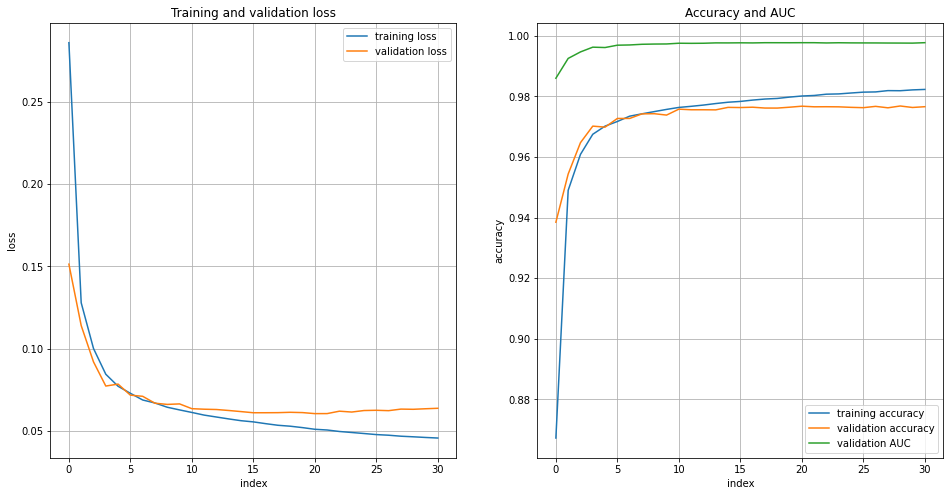

Starting attempt 2 in fold 0
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.877405	0.264680	0.936222	0.152788	0.987579	0:00:27.378643
1	0.949706	0.121809	0.955967	0.109144	0.992687	0:00:49.072596
2	0.960588	0.100368	0.965022	0.093336	0.994579	0:01:10.804417
3	0.967106	0.085780	0.968022	0.082462	0.995978	0:01:32.670321
4	0.970288	0.077039	0.970767	0.076778	0.996260	0:01:54.571336
5	0.971867	0.072919	0.972889	0.071665	0.996858	0:02:16.184338
6	0.973135	0.069492	0.972656	0.071056	0.996994	0:02:37.832740
7	0.974343	0.066456	0.974211	0.067239	0.997145	0:02:59.638031
8	0.975136	0.063952	0.973489	0.068235	0.997106	0:03:21.491205
9	0.975459	0.063590	0.974278	0.067047	0.997157	0:03:43.421657
10	0.976273	0.061473	0.975856	0.063318	0.997483	0:04:05.336416
11	0.976807	0.059407	0.975822	0.063931	0.997466	0:04:25.521404
12	0.977365	0.058282	0.976567	0.062153	0.997556	0:04:45.348541
13	0.977767	0.057141	0.976167	0.062261	0.997594	0:05:04.689434
14	0.978180	0.056092	0.976078	0.06

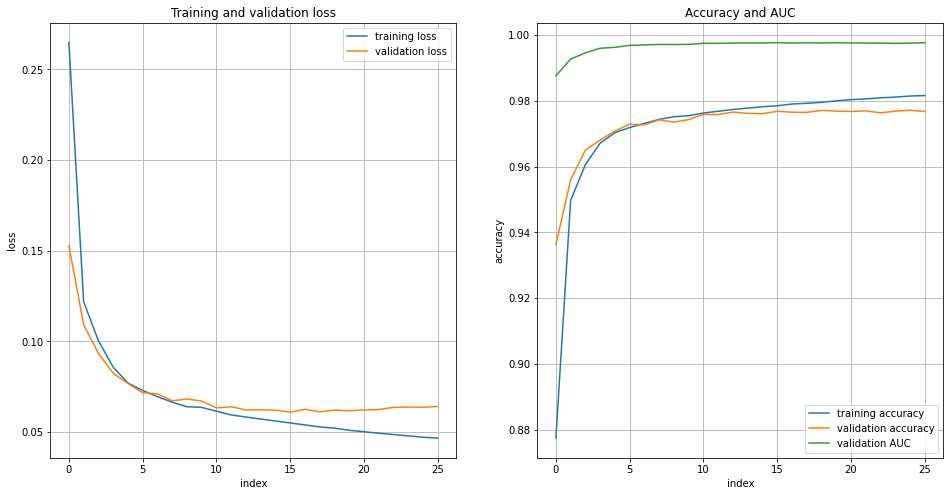

Performed fold 0 attempt 2
Starting fold 1
Starting attempt 0 in fold 1
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.861846	0.305390	0.936444	0.162628	0.985275	0:00:26.246714
1	0.947448	0.133859	0.951767	0.126470	0.990317	0:00:46.766093
2	0.959410	0.104785	0.961956	0.096400	0.994322	0:01:07.529909
3	0.965230	0.090010	0.968111	0.084154	0.995668	0:01:28.223294
4	0.968663	0.080949	0.968322	0.083326	0.996053	0:01:48.715852
5	0.970742	0.076127	0.969689	0.079564	0.996186	0:02:09.229762
6	0.971979	0.072436	0.972511	0.071355	0.996794	0:02:29.449079
7	0.973432	0.068684	0.973100	0.069957	0.996931	0:02:49.928224
8	0.974211	0.066556	0.972700	0.070982	0.996874	0:03:10.756154
9	0.974979	0.064527	0.973511	0.069007	0.997103	0:03:31.497822
10	0.975464	0.063199	0.974189	0.067844	0.997193	0:03:52.242200
11	0.976106	0.061751	0.974711	0.066156	0.997289	0:04:12.978700
12	0.976500	0.060389	0.975122	0.065311	0.997347	0:04:33.160917
13	0.977080	0.058941	0.975444	0.064111	0.997412	0:04:5

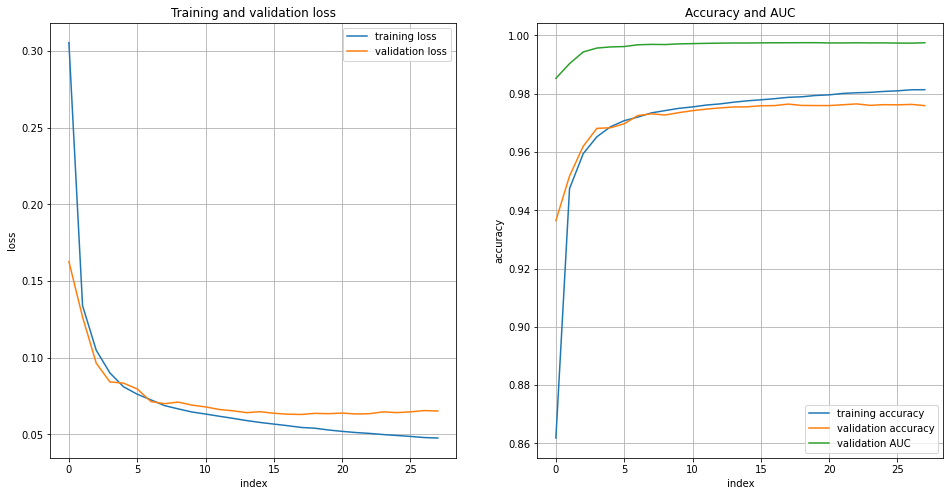

Starting attempt 1 in fold 1
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.858453	0.307754	0.935433	0.170588	0.981883	0:00:26.033741
1	0.946319	0.140951	0.953511	0.121451	0.990981	0:00:45.965381
2	0.957482	0.111990	0.960656	0.102888	0.993395	0:01:05.935965
3	0.958449	0.113507	0.945389	0.145035	0.986691	0:01:25.822297
4	0.961470	0.103433	0.950011	0.128449	0.991253	0:01:45.375610
5	0.962106	0.099589	0.964689	0.089985	0.995099	0:02:05.641812
6	0.964765	0.093008	0.955889	0.117539	0.991349	0:02:25.893249
7	0.964253	0.093205	0.966133	0.088738	0.995000	0:02:46.187074
8	0.968986	0.081321	0.968700	0.083849	0.995441	0:03:06.140701
9	0.971058	0.076493	0.970811	0.079459	0.995930	0:03:26.621849
10	0.972391	0.072813	0.971533	0.073609	0.996591	0:03:47.002116
11	0.973635	0.069354	0.972089	0.072454	0.996685	0:04:07.258477
12	0.973479	0.070095	0.972589	0.071229	0.996783	0:04:27.544052
13	0.974586	0.066560	0.973033	0.070770	0.996806	0:04:48.192046
14	0.975154	0.065107	0.973889	0.06

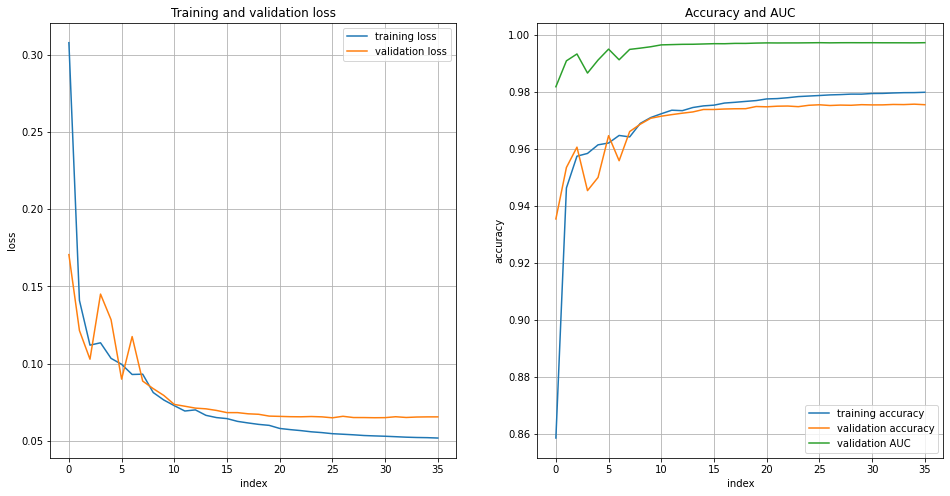

Starting attempt 2 in fold 1
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.867169	0.293412	0.927856	0.177235	0.980892	0:00:26.417443
1	0.938900	0.152465	0.944778	0.140803	0.988345	0:00:47.183080
2	0.953414	0.123296	0.957167	0.114104	0.991922	0:01:07.715482
3	0.959902	0.105232	0.963700	0.095356	0.994247	0:01:27.993375
4	0.964895	0.091929	0.966611	0.086388	0.995352	0:01:48.076021
5	0.968757	0.081209	0.970178	0.079522	0.995989	0:02:08.285950
6	0.970583	0.076206	0.969956	0.078053	0.996244	0:02:28.835456
7	0.972132	0.071900	0.971244	0.075120	0.996593	0:02:49.196575
8	0.973141	0.069302	0.971778	0.072640	0.996690	0:03:09.489475
9	0.974084	0.066763	0.972533	0.070679	0.996893	0:03:29.723778
10	0.974828	0.064833	0.973189	0.069231	0.996997	0:03:50.230902
11	0.975695	0.062910	0.973589	0.068162	0.997073	0:04:10.450302
12	0.975999	0.061632	0.974767	0.065908	0.997294	0:04:30.511762
13	0.976827	0.059839	0.974944	0.064958	0.997362	0:04:50.772683
14	0.977352	0.058605	0.974867	0.06

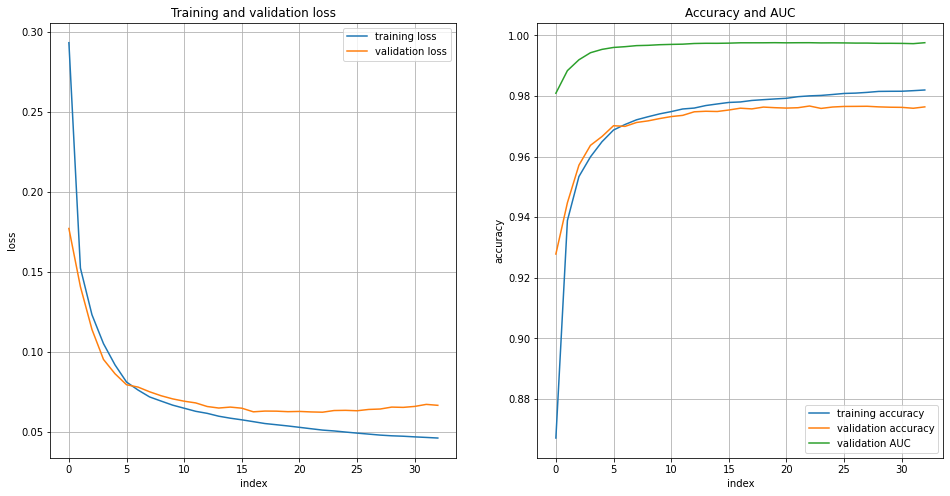

Performed fold 1 attempt 2
Starting fold 2
Starting attempt 0 in fold 2
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.864153	0.317783	0.847611	0.408263	0.929942	0:00:25.454611
1	0.927259	0.201681	0.938900	0.175453	0.981560	0:00:45.994396
2	0.945383	0.156027	0.944922	0.153292	0.986068	0:01:06.928978
3	0.954398	0.128881	0.958100	0.114656	0.990700	0:01:27.424706
4	0.960049	0.104875	0.963933	0.094673	0.994160	0:01:48.500086
5	0.965458	0.091307	0.966511	0.087095	0.995296	0:02:08.857615
6	0.968302	0.082397	0.969789	0.077837	0.996218	0:02:29.365570
7	0.970610	0.076421	0.971244	0.073898	0.996596	0:02:49.613914
8	0.972011	0.072797	0.972111	0.073563	0.996686	0:03:10.096250
9	0.973172	0.069410	0.973211	0.069197	0.997041	0:03:30.818226
10	0.974219	0.066913	0.973911	0.069173	0.996967	0:03:51.363377
11	0.974785	0.065191	0.974178	0.066105	0.997280	0:04:11.860127
12	0.975444	0.063276	0.975089	0.065199	0.997374	0:04:32.188963
13	0.976079	0.061788	0.975433	0.064206	0.997421	0:04:5

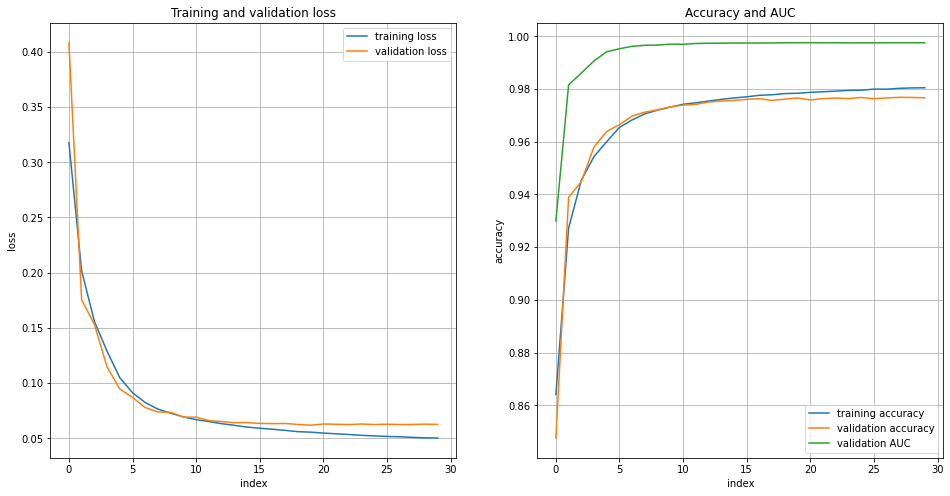

Starting attempt 1 in fold 2
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.872975	0.276727	0.940733	0.151640	0.985670	0:00:26.329107
1	0.949004	0.131116	0.952667	0.122073	0.990833	0:00:47.075280
2	0.956926	0.111919	0.960211	0.101708	0.993621	0:01:07.548954
3	0.963254	0.095668	0.966522	0.088455	0.995090	0:01:27.575446
4	0.968388	0.084436	0.968978	0.081609	0.995781	0:01:47.675537
5	0.969393	0.081454	0.970056	0.079220	0.996054	0:02:07.740828
6	0.971236	0.076422	0.971011	0.075570	0.996413	0:02:28.157938
7	0.972806	0.071629	0.972911	0.070506	0.996864	0:02:48.629950
8	0.974462	0.066818	0.973889	0.068587	0.997069	0:03:09.142720
9	0.975185	0.064926	0.974822	0.065905	0.997292	0:03:29.723084
10	0.976125	0.062313	0.974800	0.064779	0.997395	0:03:50.352137
11	0.976548	0.061113	0.975489	0.063619	0.997495	0:04:10.366711
12	0.976947	0.059625	0.975056	0.065637	0.997326	0:04:30.419356
13	0.977198	0.059125	0.975756	0.064955	0.997339	0:04:50.460383
14	0.977623	0.057984	0.975922	0.06

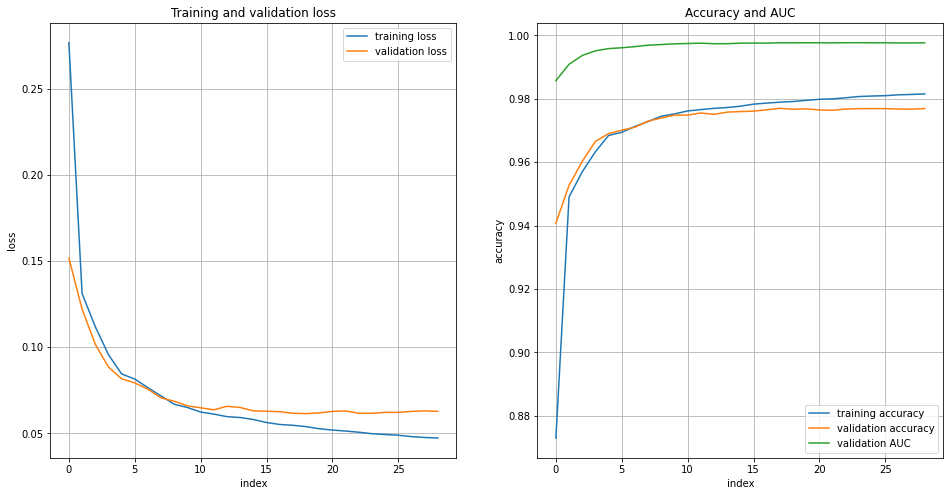

Starting attempt 2 in fold 2
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.850035	0.322181	0.939489	0.157446	0.985590	0:00:26.219514
1	0.947423	0.135838	0.953489	0.119202	0.991301	0:00:46.666837
2	0.954901	0.116992	0.960411	0.102848	0.993391	0:01:06.746062
3	0.961443	0.100527	0.960044	0.105712	0.993689	0:01:26.787126
4	0.963656	0.094482	0.963011	0.093626	0.994839	0:01:47.331908
5	0.967177	0.085101	0.965578	0.090908	0.994849	0:02:07.882473
6	0.968457	0.083126	0.968878	0.079709	0.996126	0:02:28.681248
7	0.971421	0.075701	0.971433	0.073658	0.996595	0:02:49.341495
8	0.973125	0.070530	0.973200	0.070275	0.996854	0:03:09.848297
9	0.972637	0.073648	0.966344	0.089125	0.994885	0:03:30.443072
10	0.972669	0.073534	0.973011	0.071042	0.996732	0:03:50.606300
11	0.974310	0.068962	0.973489	0.071922	0.996658	0:04:10.786412
12	0.974799	0.067295	0.973456	0.071094	0.996856	0:04:31.195127
13	0.975202	0.066073	0.974322	0.069066	0.996973	0:04:51.961603
14	0.975865	0.064487	0.974656	0.06

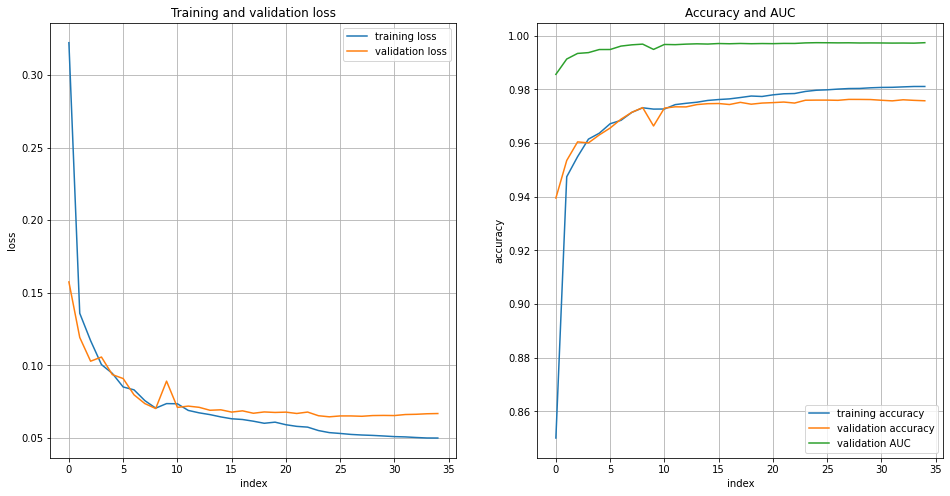

Performed fold 2 attempt 2
Starting fold 3
Starting attempt 0 in fold 3
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.872758	0.287777	0.939400	0.154253	0.985411	0:00:25.502886
1	0.944295	0.144583	0.952478	0.126931	0.989897	0:00:45.599460
2	0.954888	0.118610	0.952033	0.129381	0.990989	0:01:05.772250
3	0.955586	0.120307	0.955256	0.116086	0.992241	0:01:25.877444
4	0.959202	0.105338	0.962311	0.095084	0.994467	0:01:45.938294
5	0.961095	0.097174	0.964378	0.089016	0.995206	0:02:06.095886
6	0.963957	0.090730	0.962144	0.096502	0.994442	0:02:26.618031
7	0.965526	0.086437	0.966467	0.083359	0.995775	0:02:46.972833
8	0.966473	0.082927	0.967400	0.078864	0.996169	0:03:06.754069
9	0.967911	0.080969	0.970678	0.074112	0.996582	0:03:27.306496
10	0.970884	0.074074	0.971267	0.072532	0.996755	0:03:48.013764
11	0.972538	0.070907	0.971956	0.071267	0.996833	0:04:08.504608
12	0.973548	0.069308	0.973867	0.067581	0.997126	0:04:29.114465
13	0.972423	0.069232	0.972900	0.068644	0.997049	0:04:4

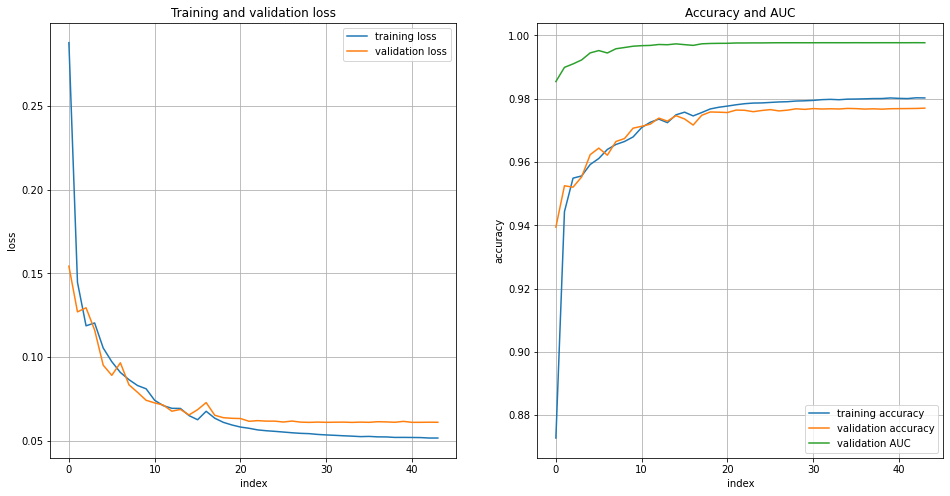

Starting attempt 1 in fold 3
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.841042	0.349993	0.926800	0.196011	0.976285	0:00:26.011081
1	0.927511	0.192981	0.938267	0.167306	0.983020	0:00:46.038702
2	0.944425	0.147464	0.948222	0.136117	0.988795	0:01:06.166900
3	0.950089	0.132364	0.952489	0.132459	0.988995	0:01:26.189404
4	0.954509	0.122391	0.956111	0.117726	0.991909	0:01:46.061735
5	0.960489	0.106181	0.963889	0.097444	0.993996	0:02:06.224178
6	0.963522	0.098132	0.962356	0.098265	0.993902	0:02:27.329193
7	0.947843	0.140544	0.951900	0.127181	0.990879	0:02:47.677373
8	0.958027	0.110992	0.961500	0.101372	0.993562	0:03:08.158159
9	0.960436	0.104444	0.960122	0.103984	0.993570	0:03:28.245321
10	0.963075	0.095462	0.964900	0.091910	0.994717	0:03:48.764150
11	0.965427	0.090302	0.965944	0.089097	0.995062	0:04:09.182489
12	0.966526	0.087916	0.966811	0.088422	0.995350	0:04:29.637029
13	0.967452	0.085300	0.968056	0.084908	0.995462	0:04:49.825566
14	0.968054	0.084173	0.967833	0.08

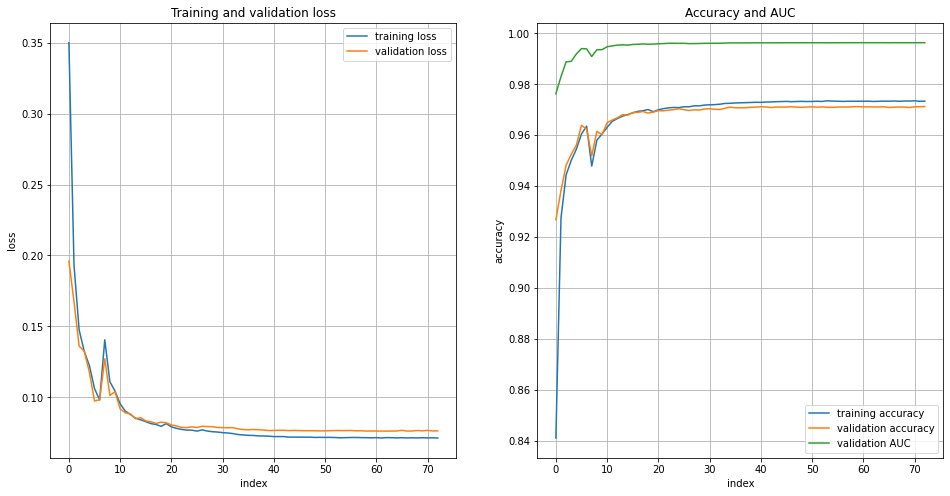

Starting attempt 2 in fold 3
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.859010	0.322427	0.921922	0.210865	0.973799	0:00:25.888236
1	0.919799	0.206448	0.932733	0.177546	0.980602	0:00:46.490519
2	0.937531	0.158295	0.944222	0.139145	0.989316	0:01:06.771365
3	0.950540	0.123728	0.953156	0.122987	0.990899	0:01:27.118412
4	0.955410	0.114340	0.956378	0.108793	0.993061	0:01:46.999319
5	0.961353	0.098764	0.956567	0.109051	0.992987	0:02:07.529958
6	0.965330	0.089317	0.966878	0.084314	0.995622	0:02:28.019029
7	0.968701	0.080179	0.968189	0.081724	0.996065	0:02:48.336471
8	0.970262	0.077792	0.971067	0.075588	0.996440	0:03:09.019970
9	0.972701	0.070853	0.972678	0.070730	0.996879	0:03:29.710345
10	0.973846	0.067683	0.973900	0.068437	0.997058	0:03:50.451634
11	0.974563	0.065900	0.974844	0.066012	0.997269	0:04:10.993375
12	0.975542	0.063066	0.974722	0.065632	0.997284	0:04:31.710742
13	0.975930	0.062433	0.975189	0.065143	0.997401	0:04:52.009216
14	0.976783	0.059924	0.976056	0.06

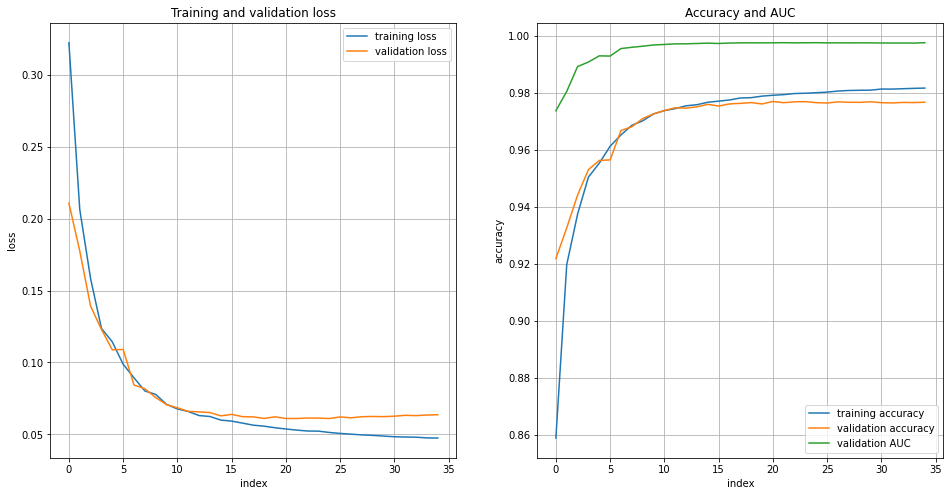

Performed fold 3 attempt 2
Starting fold 4
Starting attempt 0 in fold 4
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.867865	0.289410	0.935211	0.164510	0.983443	0:00:26.073199
1	0.944044	0.143403	0.951622	0.123194	0.990617	0:00:46.885125
2	0.956621	0.112000	0.959111	0.106293	0.992966	0:01:07.668019
3	0.962904	0.096418	0.964889	0.091624	0.994707	0:01:28.222503
4	0.966504	0.086590	0.965222	0.090056	0.994898	0:01:48.028145
5	0.968323	0.082092	0.965344	0.087599	0.995547	0:02:08.733432
6	0.971558	0.073862	0.971622	0.072798	0.996683	0:02:29.125261
7	0.972818	0.070115	0.973089	0.070686	0.996848	0:02:49.258531
8	0.974122	0.066958	0.973167	0.070639	0.997067	0:03:09.496039
9	0.974865	0.064416	0.974300	0.068749	0.997112	0:03:30.322017
10	0.975946	0.062478	0.974400	0.067238	0.997185	0:03:50.778418
11	0.976507	0.061078	0.975322	0.064361	0.997381	0:04:11.201419
12	0.976959	0.059459	0.975156	0.064747	0.997394	0:04:31.501677
13	0.977501	0.058391	0.975667	0.063871	0.997442	0:04:5

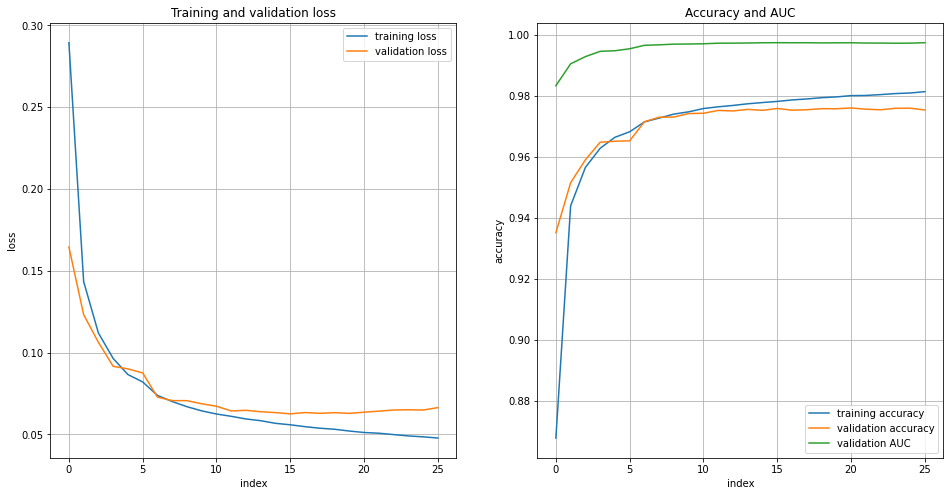

Starting attempt 1 in fold 4
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.850606	0.316405	0.943100	0.140537	0.987923	0:00:25.704374
1	0.948868	0.127721	0.955333	0.112883	0.992438	0:00:46.133244
2	0.960183	0.101202	0.961389	0.095973	0.994644	0:01:06.623769
3	0.965481	0.088425	0.968444	0.081619	0.995880	0:01:27.269798
4	0.969678	0.078622	0.970156	0.076869	0.996381	0:01:47.593719
5	0.971970	0.072608	0.971489	0.072459	0.996746	0:02:08.511857
6	0.973280	0.069685	0.972889	0.070763	0.996880	0:02:29.232177
7	0.974081	0.067034	0.973856	0.067690	0.997195	0:02:49.662597
8	0.974933	0.064909	0.974611	0.066371	0.997241	0:03:09.483811
9	0.975805	0.062728	0.973678	0.068074	0.997083	0:03:29.066578
10	0.976049	0.061793	0.974811	0.065657	0.997312	0:03:48.931960
11	0.976802	0.059960	0.975333	0.064612	0.997452	0:04:09.756666
12	0.977375	0.058537	0.975844	0.063291	0.997493	0:04:29.958737
13	0.977707	0.057618	0.975756	0.063233	0.997571	0:04:50.486040
14	0.978179	0.056280	0.976256	0.06

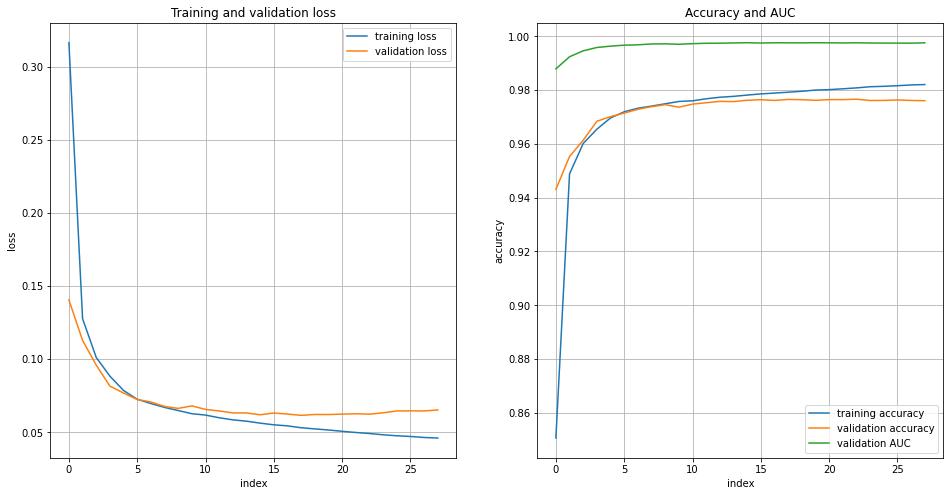

Starting attempt 2 in fold 4
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.851084	0.324383	0.937511	0.162969	0.983498	0:00:26.081711
1	0.945053	0.144596	0.950411	0.129530	0.989690	0:00:46.148196
2	0.953954	0.121828	0.957478	0.110138	0.992533	0:01:06.550076
3	0.959786	0.105928	0.958433	0.110664	0.992255	0:01:26.919676
4	0.963880	0.095720	0.966722	0.087398	0.995299	0:01:47.117432
5	0.968928	0.080221	0.967800	0.082571	0.995756	0:02:07.242708
6	0.971285	0.074369	0.971767	0.074032	0.996527	0:02:27.296382
7	0.972415	0.070795	0.972811	0.070721	0.996858	0:02:47.824156
8	0.973711	0.068097	0.973089	0.070412	0.997057	0:03:08.308861
9	0.970768	0.075697	0.971922	0.071752	0.996798	0:03:28.404128
10	0.974610	0.065682	0.973100	0.069105	0.997193	0:03:48.520800
11	0.975699	0.062565	0.975100	0.064716	0.997399	0:04:08.220095
12	0.976522	0.060682	0.974433	0.065993	0.997359	0:04:27.767991
13	0.977037	0.059565	0.974922	0.065078	0.997355	0:04:48.242430
14	0.977228	0.058692	0.975189	0.06

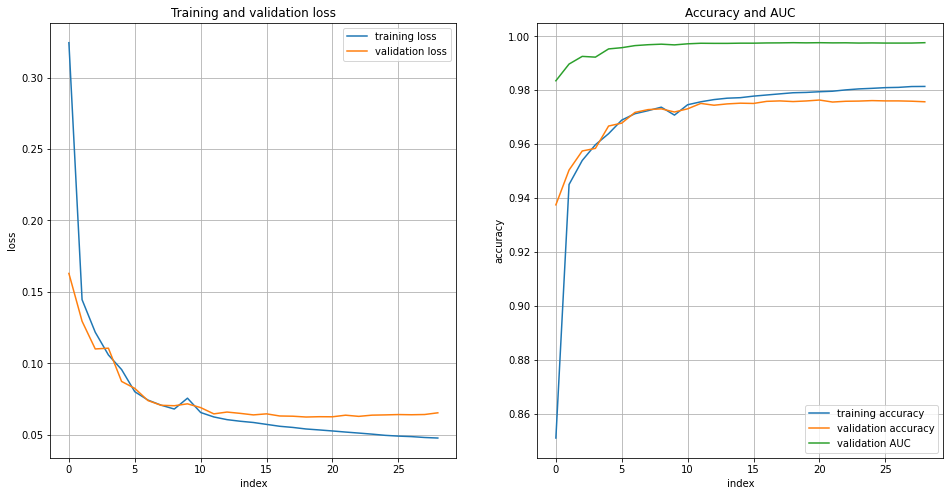

Performed fold 4 attempt 2
Starting fold 5
Starting attempt 0 in fold 5
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.850868	0.315002	0.926778	0.186122	0.982317	0:00:27.158165
1	0.948435	0.130993	0.955611	0.115173	0.991756	0:00:48.874184
2	0.960725	0.102108	0.960511	0.101903	0.993844	0:01:10.772436
3	0.964993	0.091249	0.966200	0.086791	0.995460	0:01:32.694153
4	0.968180	0.082684	0.967822	0.083374	0.995755	0:01:54.664699
5	0.970874	0.076492	0.970844	0.076090	0.996431	0:02:16.681346
6	0.972262	0.072924	0.971778	0.075007	0.996444	0:02:38.464756
7	0.973743	0.068579	0.973078	0.070726	0.996969	0:03:00.441438
8	0.974710	0.065561	0.974089	0.067774	0.997148	0:03:22.328263
9	0.975522	0.063103	0.974311	0.066600	0.997265	0:03:44.381641
10	0.976184	0.061476	0.974422	0.066631	0.997222	0:04:06.281466
11	0.976658	0.059918	0.974689	0.064362	0.997454	0:04:27.980152
12	0.977204	0.059117	0.975011	0.065010	0.997394	0:04:49.818113
13	0.977818	0.057418	0.975378	0.063627	0.997517	0:05:1

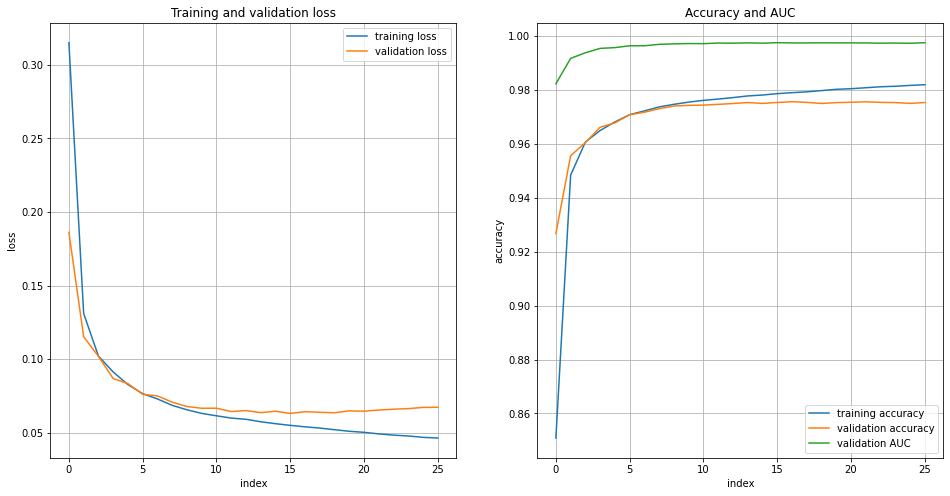

Starting attempt 1 in fold 5
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.858069	0.305413	0.939078	0.158752	0.984729	0:00:27.476162
1	0.948149	0.136968	0.955044	0.117540	0.991282	0:00:49.334835
2	0.957551	0.112237	0.961444	0.103092	0.993209	0:01:11.189143
3	0.963730	0.095973	0.964978	0.094662	0.994465	0:01:32.920794
4	0.966406	0.088903	0.965022	0.096056	0.994150	0:01:54.704765
5	0.966301	0.090225	0.966467	0.087883	0.995265	0:02:16.606241
6	0.970270	0.078369	0.969878	0.079023	0.996396	0:02:38.402753
7	0.970314	0.078228	0.968767	0.080887	0.996540	0:03:00.320531
8	0.972999	0.070321	0.972989	0.071608	0.996814	0:03:22.066236
9	0.973944	0.068213	0.973311	0.069304	0.997016	0:03:43.774803
10	0.974577	0.065944	0.972244	0.072215	0.996760	0:04:05.562840
11	0.975559	0.063262	0.974289	0.067448	0.997157	0:04:27.295119
12	0.975902	0.062564	0.973122	0.071608	0.997053	0:04:49.070837
13	0.976754	0.059986	0.974822	0.064983	0.997449	0:05:10.756553
14	0.977441	0.058135	0.975244	0.06

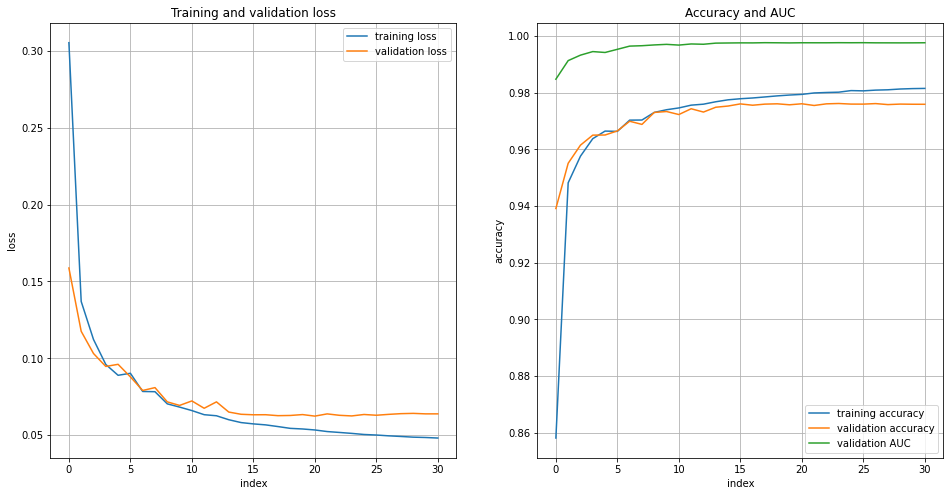

Starting attempt 2 in fold 5
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.866338	0.287658	0.936622	0.155472	0.985299	0:00:27.362829
1	0.945802	0.130789	0.951967	0.114013	0.992094	0:00:49.179719
2	0.956317	0.105036	0.962567	0.094629	0.994501	0:01:10.968519
3	0.966299	0.086331	0.967056	0.085182	0.995641	0:01:32.720494
4	0.969469	0.079092	0.966978	0.082911	0.996067	0:01:54.545327
5	0.971869	0.072722	0.972022	0.072074	0.996788	0:02:16.465409
6	0.973659	0.067919	0.972156	0.071265	0.996910	0:02:38.285626
7	0.974623	0.065678	0.973867	0.067038	0.997210	0:03:00.155903
8	0.975419	0.063674	0.974678	0.065977	0.997318	0:03:22.014844
9	0.976153	0.061832	0.974822	0.064639	0.997410	0:03:43.879267
10	0.976572	0.060571	0.974000	0.066180	0.997390	0:04:05.769022
11	0.977031	0.059074	0.975189	0.064201	0.997482	0:04:27.532059
12	0.977647	0.057717	0.974678	0.064645	0.997440	0:04:49.346050
13	0.977943	0.056813	0.975278	0.064404	0.997434	0:05:10.890485
14	0.978215	0.056137	0.975556	0.06

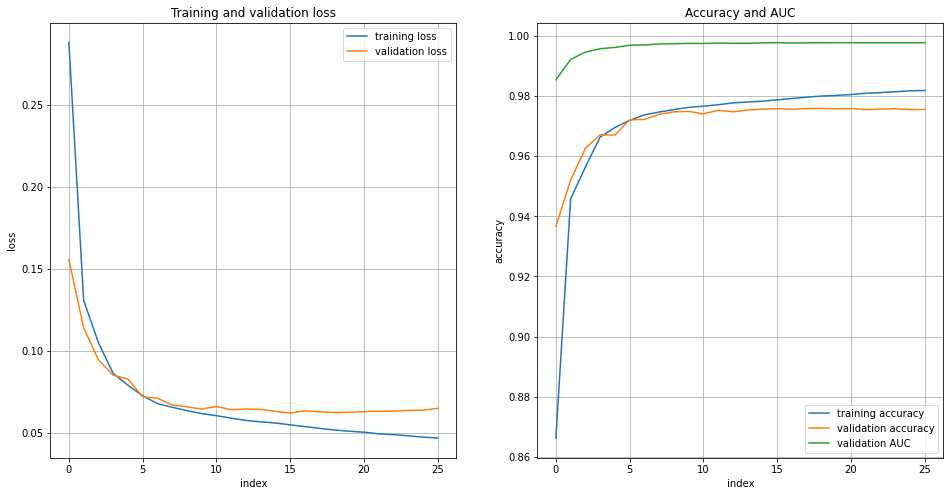

Performed fold 5 attempt 2
Starting fold 6
Starting attempt 0 in fold 6
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.856252	0.308805	0.942422	0.159799	0.984253	0:00:27.559317
1	0.947067	0.139662	0.940556	0.154287	0.985204	0:00:49.560019
2	0.953451	0.121484	0.948056	0.143137	0.987105	0:01:11.580568
3	0.957667	0.111582	0.958556	0.108133	0.992898	0:01:33.506960
4	0.961552	0.099864	0.964011	0.096938	0.993979	0:01:55.460785
5	0.963780	0.094754	0.965422	0.090485	0.994801	0:02:17.296700
6	0.965489	0.090632	0.967022	0.087321	0.995110	0:02:39.051478
7	0.966075	0.088820	0.967767	0.086223	0.995222	0:03:01.005796
8	0.966316	0.087871	0.967067	0.087626	0.995101	0:03:22.851618
9	0.967285	0.086429	0.967633	0.085572	0.995468	0:03:44.795098
10	0.968195	0.083792	0.967689	0.088030	0.995132	0:04:06.669274
11	0.968486	0.083384	0.969456	0.082504	0.995573	0:04:28.597077
12	0.969736	0.080507	0.968433	0.084863	0.995323	0:04:50.594403
13	0.970480	0.078920	0.969467	0.081497	0.995834	0:05:1

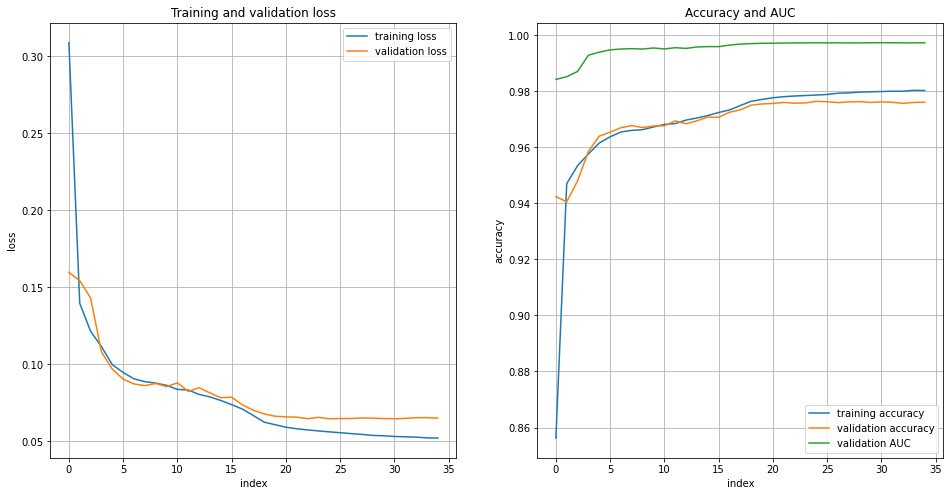

Starting attempt 1 in fold 6
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.874331	0.278764	0.934178	0.167756	0.983274	0:00:27.337295
1	0.945732	0.142323	0.951733	0.125896	0.991181	0:00:49.140716
2	0.954451	0.117604	0.956122	0.119872	0.990850	0:01:10.846136
3	0.956533	0.115293	0.960056	0.103147	0.993367	0:01:32.586552
4	0.962358	0.096872	0.965789	0.090444	0.994870	0:01:54.333388
5	0.963951	0.094294	0.965000	0.092931	0.995070	0:02:15.947924
6	0.967138	0.086930	0.970911	0.078426	0.996087	0:02:37.751913
7	0.970802	0.078141	0.971300	0.076138	0.996284	0:02:59.629801
8	0.972152	0.073886	0.969856	0.077659	0.996302	0:03:21.282822
9	0.971590	0.074085	0.972411	0.071474	0.996861	0:03:43.076432
10	0.973674	0.068441	0.974067	0.067804	0.997128	0:04:04.862670
11	0.974812	0.064760	0.975022	0.064892	0.997365	0:04:26.659584
12	0.975778	0.062579	0.975589	0.064657	0.997399	0:04:48.592294
13	0.976219	0.061387	0.975800	0.064623	0.997387	0:05:10.475635
14	0.976622	0.060957	0.976056	0.06

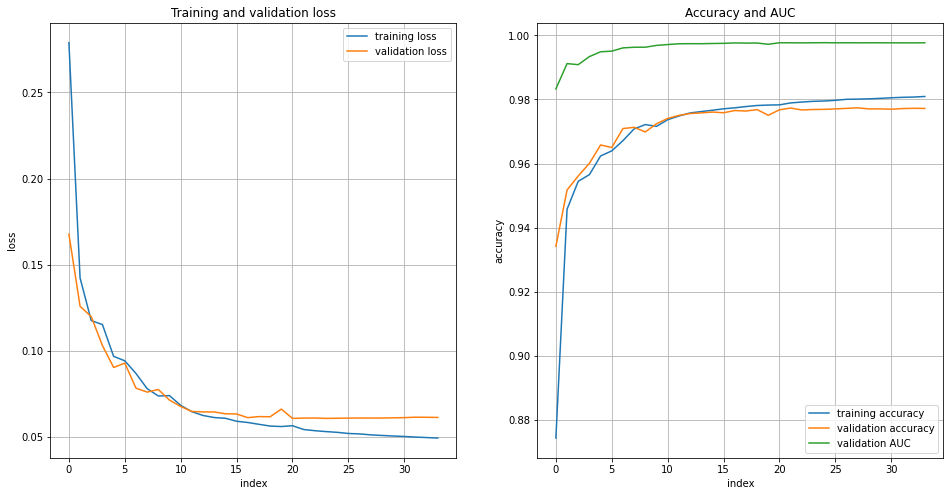

Starting attempt 2 in fold 6
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.850501	0.318291	0.923711	0.201648	0.976588	0:00:27.566123
1	0.939872	0.156675	0.948467	0.133497	0.989053	0:00:49.598398
2	0.949872	0.132337	0.952389	0.129819	0.989085	0:01:11.478385
3	0.950391	0.130235	0.952578	0.125792	0.990396	0:01:33.290681
4	0.957170	0.107437	0.961800	0.095793	0.994331	0:01:55.111826
5	0.962662	0.092092	0.965878	0.086622	0.995351	0:02:16.904045
6	0.965341	0.086449	0.966222	0.085677	0.995815	0:02:39.015734
7	0.967301	0.081979	0.969189	0.077889	0.996248	0:03:01.073911
8	0.968128	0.079875	0.967967	0.079254	0.996124	0:03:22.888104
9	0.968794	0.079721	0.969422	0.077208	0.996311	0:03:44.766235
10	0.970204	0.075130	0.970089	0.075626	0.996453	0:04:06.810596
11	0.971005	0.073366	0.970700	0.075578	0.996417	0:04:28.677375
12	0.973311	0.069074	0.973856	0.068767	0.997120	0:04:50.530366
13	0.974649	0.065396	0.975233	0.065108	0.997330	0:05:12.449558
14	0.975411	0.064119	0.975033	0.06

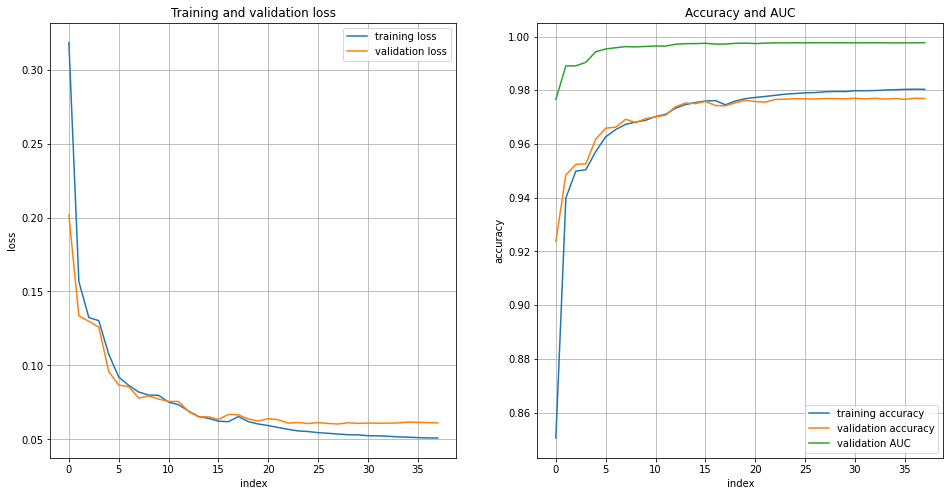

Performed fold 6 attempt 2
Starting fold 7
Starting attempt 0 in fold 7
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.855416	0.319007	0.921789	0.213404	0.972918	0:00:27.558680
1	0.931700	0.189922	0.946611	0.153318	0.985078	0:00:49.385787
2	0.939194	0.175709	0.948289	0.157030	0.983712	0:01:11.222119
3	0.950774	0.138205	0.954456	0.121102	0.990396	0:01:33.049529
4	0.956025	0.114603	0.958367	0.106221	0.992803	0:01:54.925371
5	0.959760	0.103473	0.962389	0.097015	0.994154	0:02:16.726058
6	0.954598	0.119182	0.952300	0.130830	0.989182	0:02:38.382503
7	0.957447	0.107543	0.957756	0.102583	0.993925	0:03:00.261258
8	0.961384	0.095337	0.962289	0.093096	0.994578	0:03:22.097822
9	0.963960	0.090139	0.965478	0.089730	0.994942	0:03:44.052697
10	0.965659	0.086593	0.966244	0.083631	0.995638	0:04:06.034571
11	0.968115	0.082357	0.966978	0.085652	0.995750	0:04:27.992949
12	0.969763	0.078704	0.969156	0.081889	0.995683	0:04:49.701164
13	0.971402	0.075267	0.970144	0.077379	0.996291	0:05:1

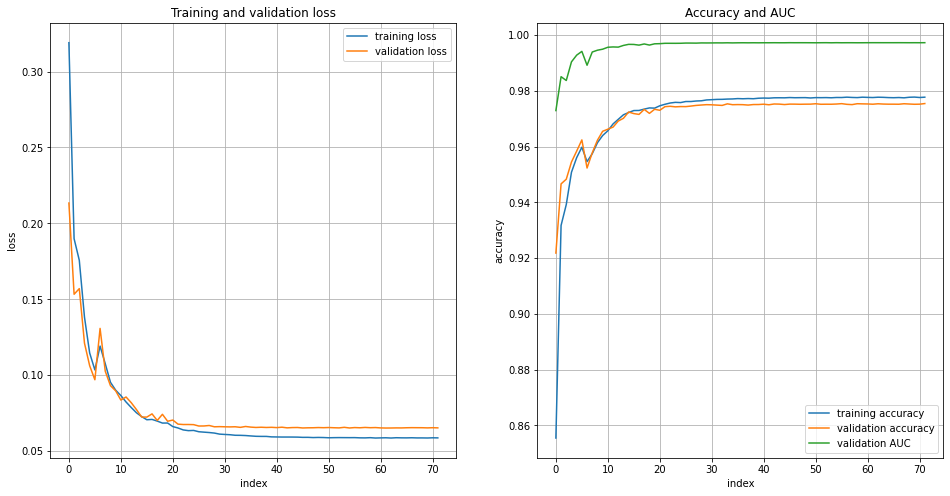

Starting attempt 1 in fold 7
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.863388	0.315361	0.932767	0.195942	0.977529	0:00:27.267038
1	0.937838	0.177710	0.945856	0.143595	0.986187	0:00:49.103611
2	0.952078	0.122161	0.955733	0.112015	0.992204	0:01:10.866871
3	0.959696	0.101734	0.961444	0.097130	0.994251	0:01:32.697865
4	0.964701	0.090304	0.967078	0.084375	0.995505	0:01:54.385077
5	0.968349	0.081851	0.969211	0.079643	0.996045	0:02:16.245859
6	0.967830	0.084523	0.969544	0.080192	0.996027	0:02:38.069174
7	0.971758	0.073154	0.971989	0.073684	0.996561	0:02:59.861324
8	0.973264	0.069811	0.973478	0.069840	0.996904	0:03:21.474009
9	0.973467	0.068448	0.971989	0.074510	0.996511	0:03:43.258729
10	0.974538	0.066023	0.973256	0.070693	0.996814	0:04:04.889676
11	0.975400	0.063374	0.974489	0.067112	0.997148	0:04:26.373901
12	0.976196	0.061352	0.974889	0.066404	0.997210	0:04:48.188326
13	0.976665	0.060161	0.974467	0.067302	0.997226	0:05:09.926753
14	0.977168	0.058988	0.975489	0.06

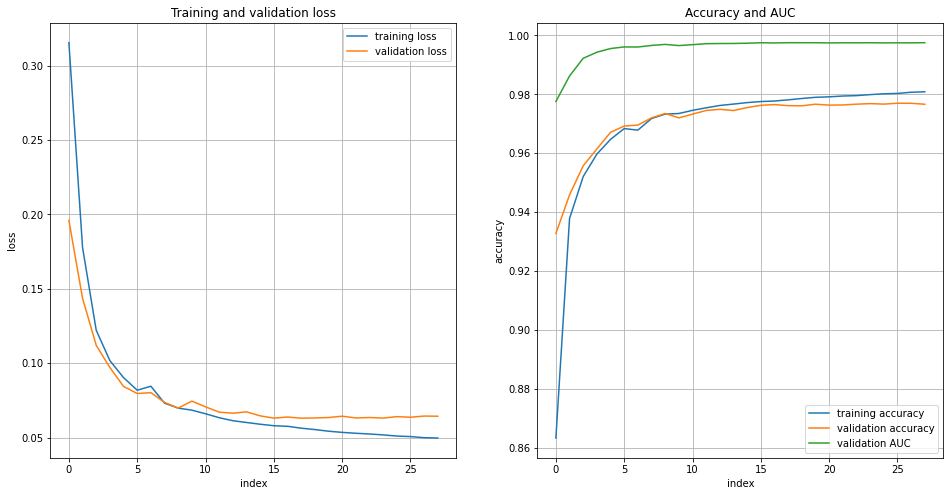

Starting attempt 2 in fold 7
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.849546	0.333823	0.928022	0.184969	0.978870	0:00:27.645939
1	0.936714	0.159190	0.949678	0.128475	0.989882	0:00:49.445937
2	0.953099	0.119969	0.957611	0.107415	0.992746	0:01:11.305469
3	0.961447	0.099410	0.964011	0.095119	0.994451	0:01:33.181594
4	0.965796	0.089625	0.968044	0.085683	0.995449	0:01:54.824316
5	0.968159	0.083512	0.967822	0.084431	0.995504	0:02:16.502429
6	0.970063	0.078495	0.969200	0.080451	0.995909	0:02:38.350161
7	0.972067	0.073116	0.971711	0.074581	0.996421	0:02:59.986144
8	0.972901	0.070527	0.972856	0.072235	0.996720	0:03:21.712624
9	0.974370	0.066414	0.973811	0.068727	0.997025	0:03:43.467463
10	0.975114	0.064613	0.973756	0.070770	0.996888	0:04:05.286520
11	0.975981	0.062508	0.974600	0.067138	0.997122	0:04:27.014054
12	0.976494	0.061165	0.974744	0.066797	0.997112	0:04:48.914234
13	0.976570	0.060337	0.975800	0.064629	0.997333	0:05:10.772934
14	0.977396	0.058635	0.975556	0.06

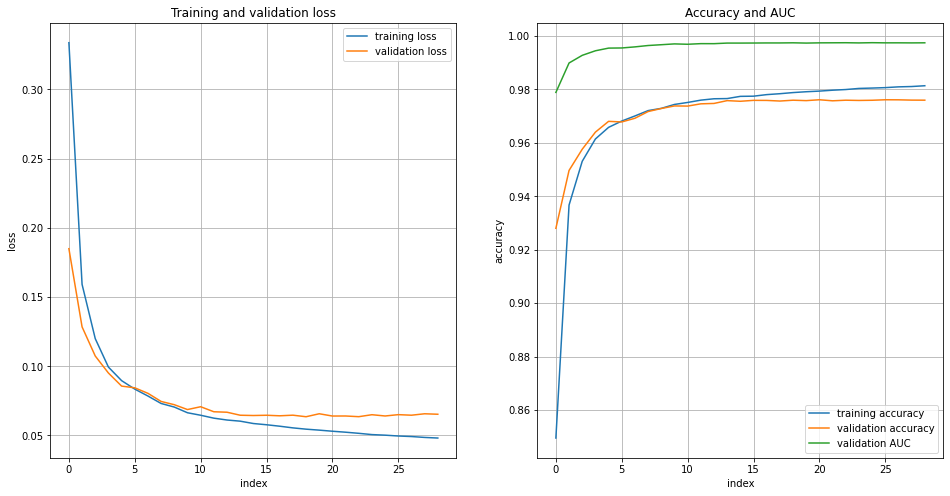

Performed fold 7 attempt 2
Starting fold 8
Starting attempt 0 in fold 8
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.866098	0.283759	0.934078	0.159859	0.984422	0:00:27.433012
1	0.947796	0.128681	0.960356	0.102769	0.993480	0:00:49.165289
2	0.961949	0.097797	0.964422	0.090352	0.995238	0:01:10.923885
3	0.966743	0.085847	0.968900	0.079862	0.996077	0:01:32.576656
4	0.969714	0.077965	0.970967	0.075339	0.996448	0:01:54.440685
5	0.971783	0.072737	0.972622	0.070794	0.996894	0:02:16.245273
6	0.972995	0.069942	0.973622	0.068869	0.997063	0:02:38.108486
7	0.974036	0.067284	0.973556	0.069027	0.997007	0:02:59.914014
8	0.974820	0.065226	0.974200	0.066835	0.997290	0:03:21.709253
9	0.975528	0.063154	0.975033	0.065275	0.997344	0:03:43.598363
10	0.976137	0.061481	0.974244	0.066913	0.997367	0:04:05.309102
11	0.976735	0.059998	0.975944	0.062043	0.997606	0:04:27.143750
12	0.977196	0.058661	0.976300	0.061726	0.997620	0:04:48.977888
13	0.977727	0.057312	0.975933	0.062922	0.997581	0:05:1

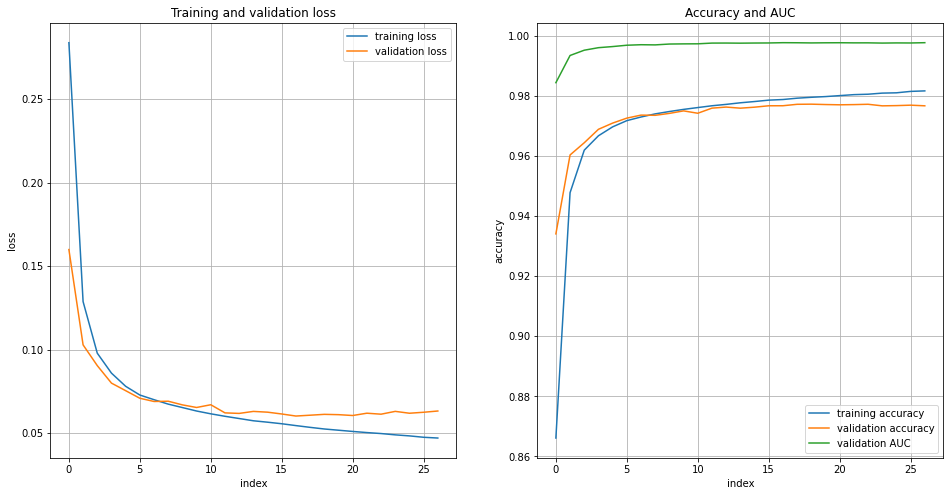

Starting attempt 1 in fold 8
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.859777	0.320048	0.930022	0.193246	0.978018	0:00:27.320482
1	0.937296	0.167520	0.949589	0.131592	0.989209	0:00:49.309321
2	0.952511	0.123475	0.926456	0.190000	0.981955	0:01:11.263771
3	0.955741	0.119863	0.954167	0.131808	0.988838	0:01:33.302519
4	0.959637	0.108272	0.962300	0.100949	0.994077	0:01:54.962319
5	0.964162	0.095406	0.965500	0.090210	0.994937	0:02:16.811318
6	0.966142	0.090213	0.966233	0.088877	0.995083	0:02:38.735702
7	0.964572	0.091832	0.966756	0.084690	0.995605	0:03:00.695165
8	0.967967	0.082147	0.968856	0.080522	0.996051	0:03:22.780163
9	0.969496	0.078224	0.970211	0.076203	0.996380	0:03:44.778640
10	0.970991	0.073339	0.971444	0.072235	0.996748	0:04:06.642553
11	0.972583	0.069181	0.971522	0.071963	0.996881	0:04:28.643422
12	0.973548	0.066944	0.972744	0.068539	0.997094	0:04:50.383181
13	0.973500	0.066910	0.971000	0.073337	0.996702	0:05:11.859349
14	0.974248	0.065026	0.973511	0.06

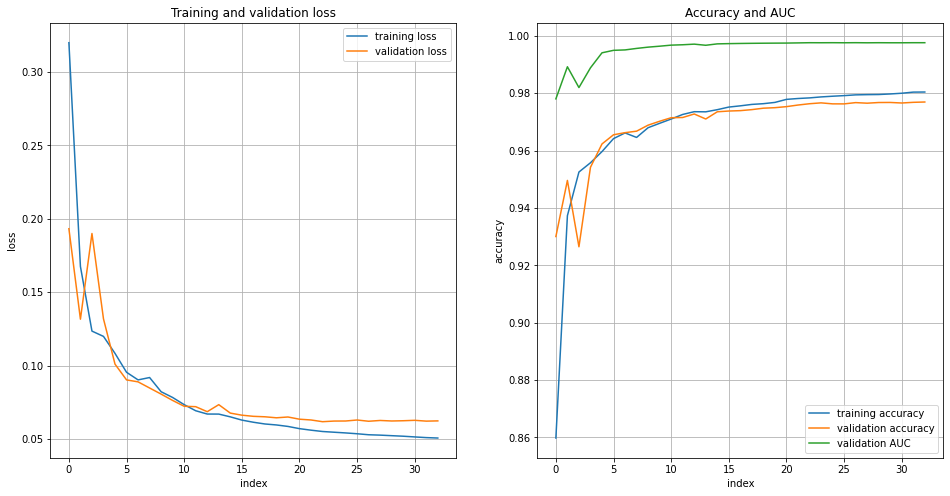

Starting attempt 2 in fold 8
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.862253	0.318280	0.923756	0.224146	0.973130	0:00:27.656529
1	0.936552	0.168978	0.947022	0.138105	0.989019	0:00:49.688371
2	0.949067	0.130907	0.957356	0.109514	0.992477	0:01:11.651314
3	0.956727	0.113114	0.958044	0.115852	0.991248	0:01:33.445093
4	0.958857	0.110286	0.962789	0.099196	0.993514	0:01:55.338990
5	0.963344	0.096657	0.965467	0.091310	0.994603	0:02:17.468066
6	0.965909	0.090413	0.967244	0.087177	0.995099	0:02:39.571365
7	0.968100	0.084541	0.970133	0.079280	0.995906	0:03:01.503177
8	0.968932	0.082883	0.970211	0.080563	0.995778	0:03:23.555109
9	0.966922	0.087022	0.966189	0.087987	0.995164	0:03:45.539539
10	0.968706	0.081578	0.970033	0.078411	0.996116	0:04:07.437919
11	0.970958	0.075411	0.971444	0.074658	0.996490	0:04:29.429827
12	0.971910	0.071999	0.971622	0.073215	0.996669	0:04:51.534400
13	0.972744	0.069684	0.972000	0.073495	0.996607	0:05:13.506140
14	0.973359	0.067788	0.972789	0.06

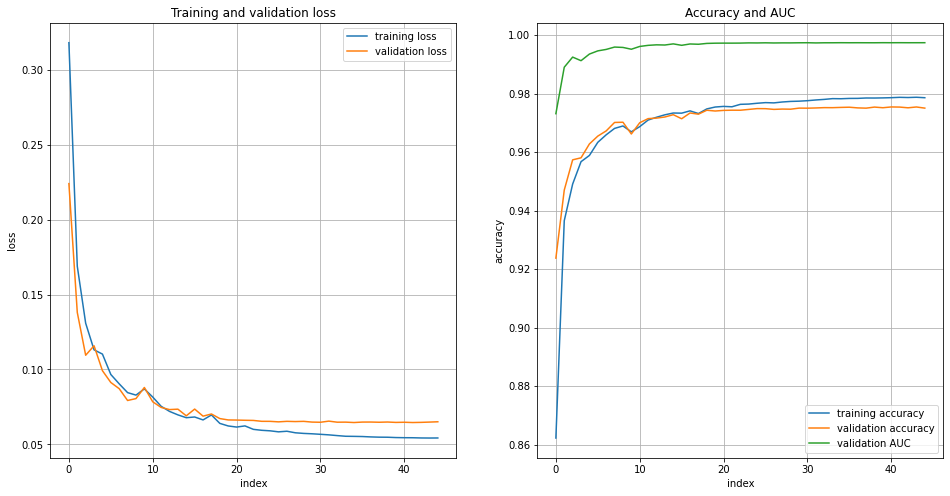

Performed fold 8 attempt 2
Starting fold 9
Starting attempt 0 in fold 9
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.872438	0.282987	0.937667	0.159576	0.984765	0:00:27.427834
1	0.946086	0.139089	0.950756	0.124093	0.990476	0:00:49.154641
2	0.956290	0.113887	0.956911	0.111216	0.992437	0:01:11.038470
3	0.959870	0.104851	0.954811	0.113817	0.992453	0:01:32.739685
4	0.961977	0.098242	0.963211	0.093516	0.994551	0:01:54.517648
5	0.965333	0.089475	0.966500	0.086003	0.995433	0:02:16.149875
6	0.967470	0.084160	0.968044	0.082950	0.995743	0:02:37.768045
7	0.965643	0.089719	0.965967	0.093530	0.994244	0:02:59.631144
8	0.966848	0.087406	0.968144	0.082657	0.995731	0:03:21.519214
9	0.969047	0.080955	0.969200	0.079238	0.996105	0:03:43.155049
10	0.970501	0.077252	0.969622	0.078460	0.996188	0:04:04.830494
11	0.971762	0.073864	0.969756	0.077188	0.996314	0:04:26.585804
12	0.971936	0.073515	0.967933	0.083920	0.995533	0:04:48.401696
13	0.971762	0.075302	0.972011	0.074593	0.996491	0:05:1

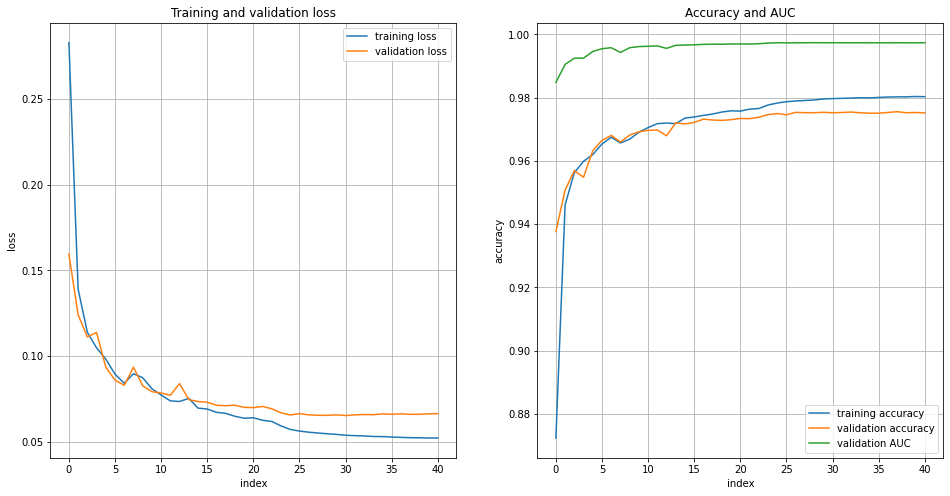

Starting attempt 1 in fold 9
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.857917	0.314729	0.900422	0.231884	0.968230	0:00:27.782768
1	0.931069	0.170404	0.938578	0.151525	0.986165	0:00:49.738702
2	0.945861	0.138670	0.953744	0.120777	0.991071	0:01:11.748770
3	0.955748	0.114144	0.958456	0.107015	0.993059	0:01:33.596014
4	0.959301	0.104900	0.959311	0.104663	0.993986	0:01:55.642863
5	0.963051	0.096444	0.960700	0.100958	0.994173	0:02:17.530753
6	0.964925	0.092058	0.964844	0.091617	0.994733	0:02:39.422756
7	0.965406	0.091773	0.966289	0.087876	0.995046	0:03:01.290883
8	0.967258	0.086924	0.967478	0.086067	0.995257	0:03:23.327491
9	0.969194	0.080794	0.968367	0.084439	0.995437	0:03:45.330926
10	0.970496	0.076785	0.970511	0.077159	0.996338	0:04:07.186961
11	0.971725	0.073608	0.970789	0.075034	0.996486	0:04:28.958450
12	0.972221	0.072947	0.970811	0.076741	0.996222	0:04:50.772259
13	0.973211	0.070134	0.972267	0.070521	0.996880	0:05:12.682925
14	0.973779	0.068429	0.972844	0.07

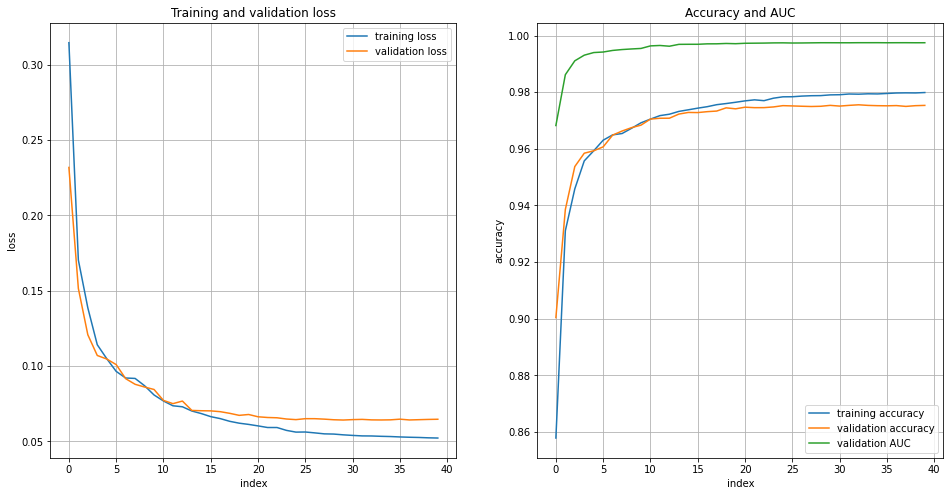

Starting attempt 2 in fold 9
No:	Train ACC:	Train loss:	Val ACC:	Val loss:	Val AUC:	Duration:
0	0.855917	0.324851	0.918578	0.216883	0.972819	0:00:27.541777
1	0.931377	0.191138	0.939733	0.170660	0.982071	0:00:49.418718
2	0.945856	0.155422	0.950033	0.144006	0.987365	0:01:11.251038
3	0.927302	0.187055	0.952222	0.151163	0.985339	0:01:33.244856
4	0.953051	0.136918	0.958133	0.117507	0.990686	0:01:55.035783
5	0.957688	0.118027	0.954244	0.136317	0.986795	0:02:16.987290
6	0.959647	0.112316	0.959556	0.107924	0.992355	0:02:38.693239
7	0.961512	0.103486	0.965189	0.095077	0.993847	0:03:00.554072
8	0.964940	0.090992	0.965711	0.088097	0.995327	0:03:22.514199
9	0.967941	0.082864	0.968967	0.081633	0.995900	0:03:44.371678
10	0.969653	0.078687	0.970000	0.077510	0.996239	0:04:06.327925
11	0.970863	0.075749	0.971256	0.074901	0.996552	0:04:28.298860
12	0.971949	0.073084	0.970833	0.074094	0.996566	0:04:50.259235
13	0.972556	0.072218	0.972378	0.072415	0.996676	0:05:12.259213
14	0.973344	0.070152	0.961867	0.10

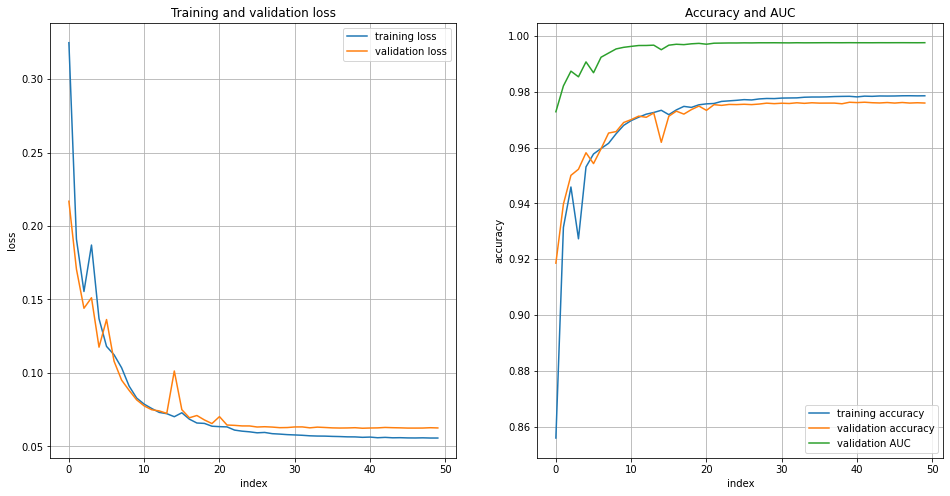

Performed fold 9 attempt 2


NameError: name 'start' is not defined

In [19]:
N_ATTEMPTS_PER_FOLD=3

# level 0 loop for folds
for idx in folds.keys():
    print(f"Starting fold {idx}")
    ss = StandardScaler()
    X_train_fold_scaled = pd.DataFrame(ss.fit_transform(folds[idx]['X_train']), 
                                       index=folds[idx]['X_train'].index, 
                                       columns=folds[idx]['X_train'].columns)
    X_val_fold_scaled = pd.DataFrame(ss.transform(folds[idx]['X_val']), 
                                     index=folds[idx]['X_val'].index, 
                                     columns=folds[idx]['X_val'].columns)
    
    # nested loop for attempts within each fold
    # each attempt operates on the same data
    for attempt in range(N_ATTEMPTS_PER_FOLD):
        print(f"Starting attempt {attempt} in fold {idx}")
        CHECKPOINTS_PATH=f"tabnet_checkpoints/{idx}_{attempt}/"
        tf.keras.backend.clear_session()

        lr = DecayWithWarmupSchedule(
            learning_rate=params['initial_learning_rate'],
            warmup=params['num_warmup_epochs'],
            decay_rate=params['lr_decay_rate'],
            decay_steps=params['decay_steps'],
            min_learning_rate=params['min_learning_rate']
        )
    
        model_tabnet_= TFTabnetClassifier(
            num_features=test_df.shape[1], 
            feature_dim=params['tabnet_feature_dim'], 
            output_dim=params['tabnet_output_dim'],
            n_classes=2, 
            n_step=params['tabnet_n_step'], 
            relaxation_factor=params['relaxation_factor'],
            bn_momentum=params['tabnet_bn_momentum'], 
            dp=params['tabnet_dp'], 
            bn_virtual_divider=params['tabnet_bn_virtual_divider'],
            output_activation='softmax'
        )

        model_tabnet_.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr,clipnorm=params['adam_clipnorm']),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')],
        )
        auc_callback = AUCCallback(validation_data=X_val_fold_scaled.values, validation_labels=folds[idx]['y_val'])
        model_tabnet_.fit(
            X_train_fold_scaled.values, folds[idx]['y_train'],
            validation_data=(X_val_fold_scaled.values, folds[idx]['y_val']),
            callbacks=[
                EarlyStopping(monitor='val_loss', mode='min', min_delta=1e-6, patience=10, restore_best_weights=True),
                auc_callback,
                ModelCheckpoint(filepath=CHECKPOINTS_PATH, 
                    monitor="val_loss", 
                    save_best_only=True, 
                    save_weights_only=True, 
                    mode="min")
            ],
            verbose=0,
            batch_size=params['batch_size'], 
            epochs= params['max_epochs'])
    
        # load the best weights
        model_tabnet_.load_weights(CHECKPOINTS_PATH)
        folds_results[((idx, attempt), 'TabNet')]= model_tabnet_.predict(X_val_fold_scaled.values)[:,1]
        fold_auc = roc_auc_score(folds[(idx)]['y_val'], folds_results[((idx, attempt), 'TabNet')])
        folds_scores[(idx, attempt)]=fold_auc
        print(f"Final fold-attempt result: {fold_auc:.6f}\n\n")
        plot_training_history(auc_callback.history)
    print("Performed fold {} attempt {}".format(idx, attempt))
print(f"Performed in {dt.datetime.now()-start}")

In [27]:
tf_tabnet_res__={
    "folds_scores": folds_scores,
    "folds": folds,
    "folds_val_predictions": folds_results,
}
with open("TabNetTensorflow_Results.pkl", "wb") as f:
    pickle.dump(tf_tabnet_res__,f)

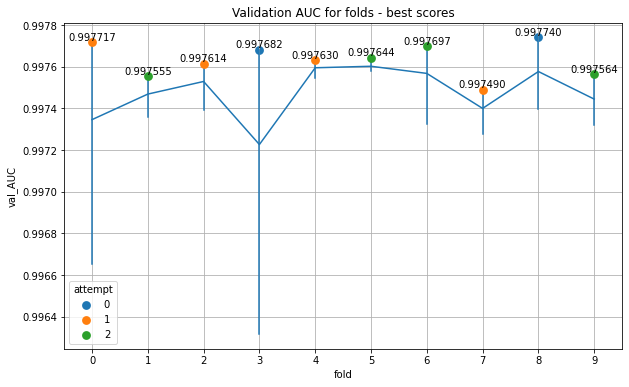

In [26]:
score_df=pd.DataFrame.from_dict(folds_scores, orient='index', columns=['val_AUC'])
score_df=score_df.reset_index()
score_df['fold']=score_df['attempt']=np.NaN
score_df['fold']=score_df['index'].apply(lambda x: x[0])
score_df['attempt']=score_df['index'].apply(lambda x: x[1])
score_df.sort_values(by=['fold','attempt']).reset_index()
score_df=score_df[['fold','attempt','val_AUC']]
fig,ax=plt.subplots(1,1,figsize=(10,6))
sns.lineplot(data=score_df, x='fold', y='val_AUC',  ax=ax, err_style='bars')
score_df_best = score_df.loc[score_df.groupby('fold')['val_AUC'].idxmax()]
sns.pointplot(data=score_df_best, x='fold', y='val_AUC', hue='attempt', linestyles='', ax=ax)
for idx, fold, val in list(score_df_best[['fold', 'val_AUC']].itertuples()):
    ax.text(fold, val, f"{val:.6f}", horizontalalignment='center', verticalalignment='bottom')
    
ax.grid('both')
ax.set_title('Validation AUC for folds - best scores');


In [22]:
for fold, attempt, val in score_df_best.values:
    CHECKPOINTS_PATH=f"tabnet_checkpoints/{int(fold)}_{int(attempt)}/"
    print(CHECKPOINTS_PATH)
    model_tabnet_.load_weights(CHECKPOINTS_PATH)
    ss.fit(folds[fold]['X_train'])
    x_val_fold_scaled=ss.transform(folds[fold]['X_val'])
    folds_results[(fold, 'TabNet')]= model_tabnet_.predict(x_val_fold_scaled)[:,1]
    test_df_=ss.transform(test_df)
    test_predictions[fold]=model_tabnet_.predict(test_df_)[:,1]

tabnet_checkpoints/0_1/
tabnet_checkpoints/1_2/
tabnet_checkpoints/2_1/
tabnet_checkpoints/3_0/
tabnet_checkpoints/4_1/
tabnet_checkpoints/5_2/
tabnet_checkpoints/6_2/
tabnet_checkpoints/7_1/
tabnet_checkpoints/8_0/
tabnet_checkpoints/9_2/


<AxesSubplot:>

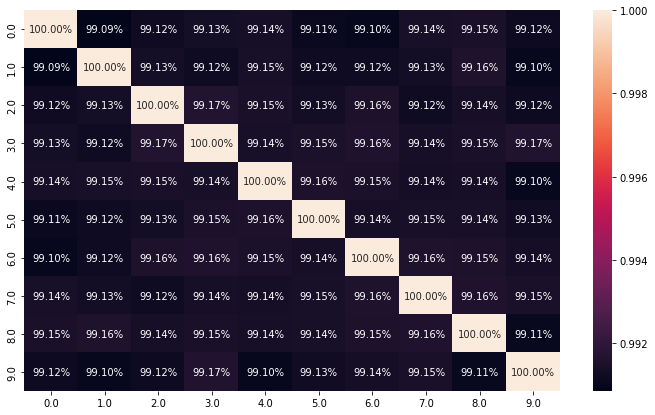

In [23]:
test_pred_df = pd.DataFrame(test_predictions)
fig,ax=plt.subplots(1,1,figsize=(12,7))
sns.heatmap(test_pred_df.corr(), annot=True, fmt=".2%")


## Mean prediction using all data

In [24]:
with open("TFTabNetResults_test_preds_1.pkl", "wb") as f:
    pickle.dump(test_predictions, f)

In [25]:
res_=pd.DataFrame(test_pred_df.mean(axis=1),  columns=['target'])
res_. index=test_df.index
res_.to_csv("Finalsolution_data30_TFTabNet_AttemptSelection.csv")

- This submission scored 0.99811 on public leaderboard when no attempt selection was performed (for each foild only single attempt was performed)
- With attempt selection publi score is 0.99810.

> **Conclusion - selecting attempt (local optimization among several results for the same fold train data does not introduce any improvement)**
